<a href="https://colab.research.google.com/github/QuantumQist/PINN_Damped_Harmonic_Oscillator/blob/main/PINN_YT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Importy

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from tqdm.auto import tqdm

# 1. Liczenie pochodnych

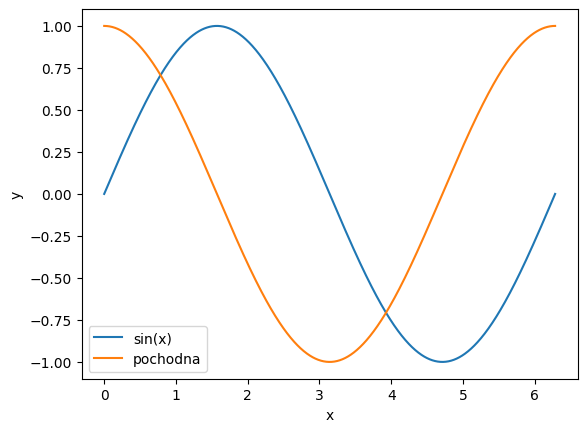

In [4]:
x = torch.linspace(0, 2*torch.pi, 1000, requires_grad=True)

y = torch.sin(x)

dydx = torch.autograd.grad(y, x, grad_outputs=torch.ones_like(y))[0]

plt.plot(x.detach(), y.detach(), label="sin(x)")
plt.plot(x.detach(), dydx.detach(), label="pochodna")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

# 2. Sieć neuronowa.

In [73]:
pinn = nn.Sequential(
    nn.Linear(1, 32),
    nn.Tanh(),
    nn.Linear(32,32),
    nn.Tanh(),
    nn.Linear(32,1)
)

# 3. Parametry układu fizycznego

In [74]:
# Paramtery fizyczne układu
GAMMA = 0.2
W_0 = 2
T_MAX = 10

# Warunki początkowe
x0_tensor = torch.tensor([1.0]).view(-1,1)
v0_tensor = torch.tensor([0.0]).view(-1,1)
t0_tensor = torch.tensor(0.0, requires_grad=True).view(-1,1)

# Punkty do wyznaczania straty fizycznej
t_tensor = torch.linspace(0, T_MAX, 100, requires_grad=True).view(-1,1)

# 4. Ewaluacja sieci przed treningiem.

In [75]:
def ground_truth(t_array, gamma, w_0):
    """
    Zwraca poprawny wynik.
    """
    assert gamma < w_0, "gamma>=w_0, niezgodne z reżimem słaych tłumień"

    w = np.sqrt(w_0**2 + gamma**2)
    decay = np.exp(-gamma*t_array)
    bracket = np.cos(w*t_array) + (gamma / w) * np.sin(w*t_array)

    return decay * bracket

In [76]:
def plot_result(model, w_0, gamma, t_max, title=None):
    model.eval()
    t_tensor = torch.linspace(0, t_max, 1000).view(-1,1)
    with torch.inference_mode():
        x_tensor = model(t_tensor)

    t_tensor = t_tensor.numpy()
    x_tensor = x_tensor.numpy()

    ground_truth_result = ground_truth(t_tensor, gamma, w_0)

    plt.plot(t_tensor, x_tensor, label = "PINN")
    plt.plot(t_tensor, ground_truth_result, label = "Poprawny wynik")
    plt.xlabel("t")
    plt.ylabel("x(t)")
    if title is not None:
        plt.title(title)
    plt.legend()
    plt.show()

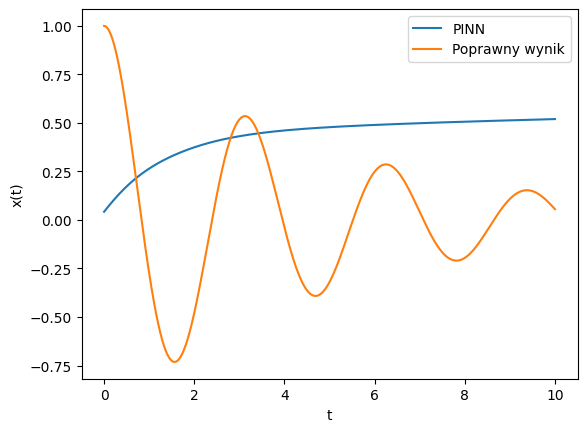

In [77]:
plot_result(pinn, W_0, GAMMA, T_MAX)

# 5. Pętla treningowa.

In [78]:
# HIPERPARAMETRY
NUM_EPOCHS = 15000
LEARNING_RATE = 0.01
LAMBDA_PHYSICS = 1.
LAMBDA_X0 = 10.
LAMBDA_V0 = 10.

  0%|          | 0/15000 [00:00<?, ?it/s]

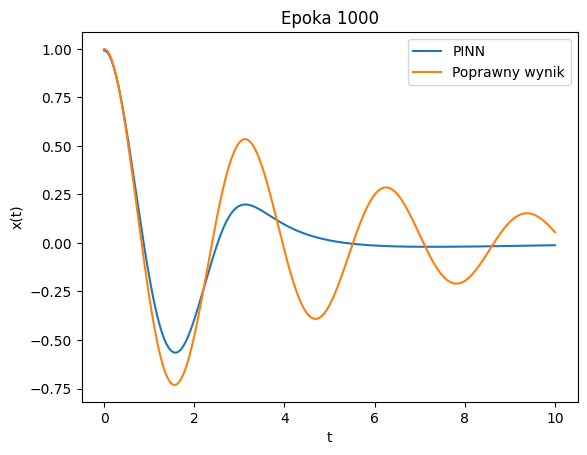

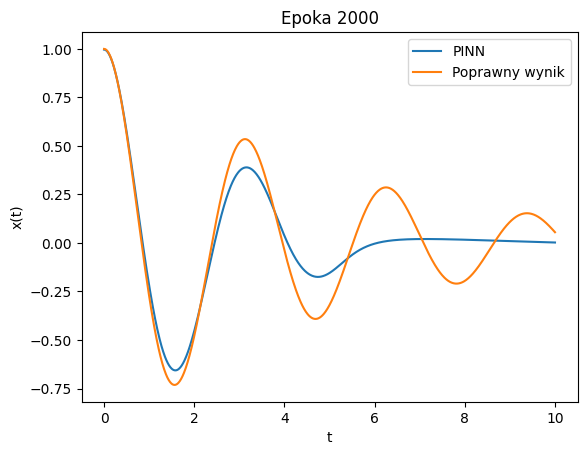

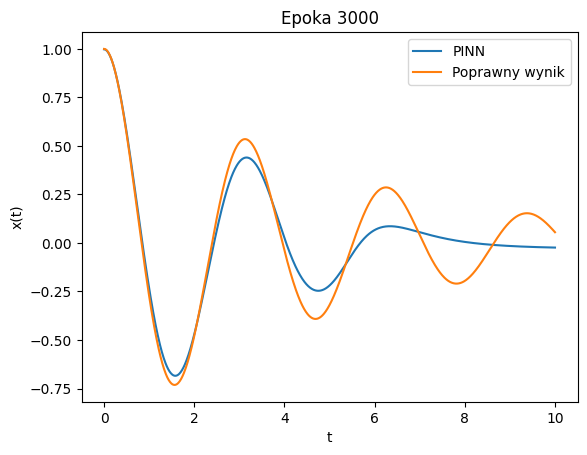

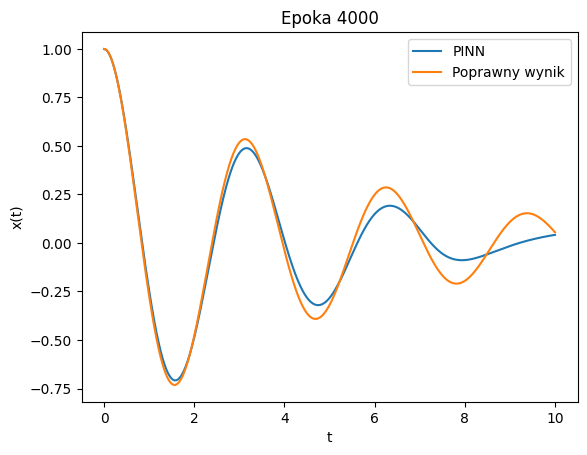

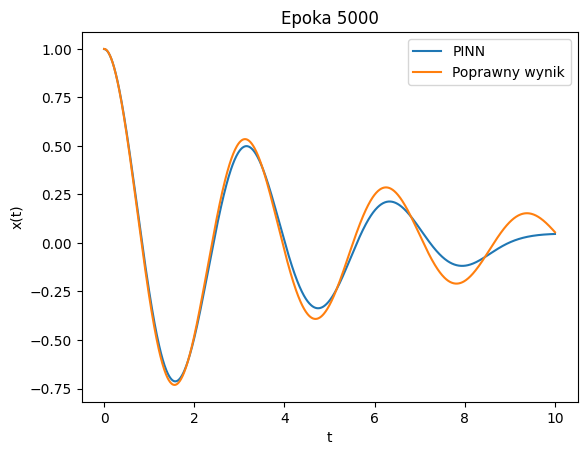

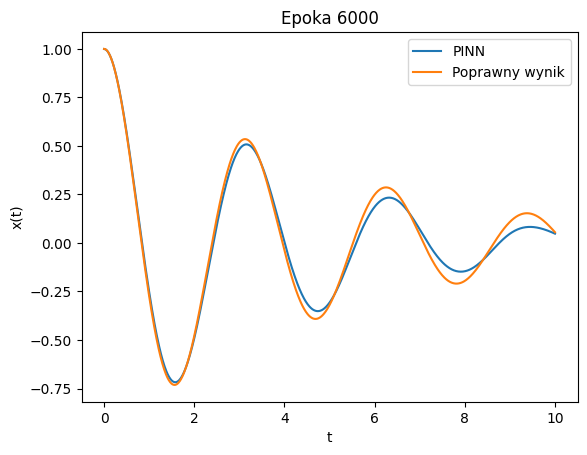

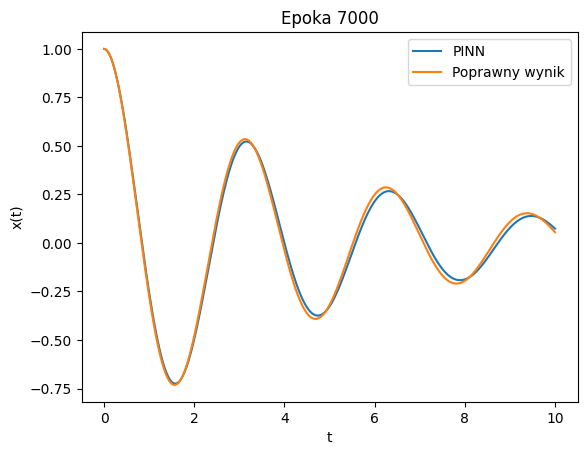

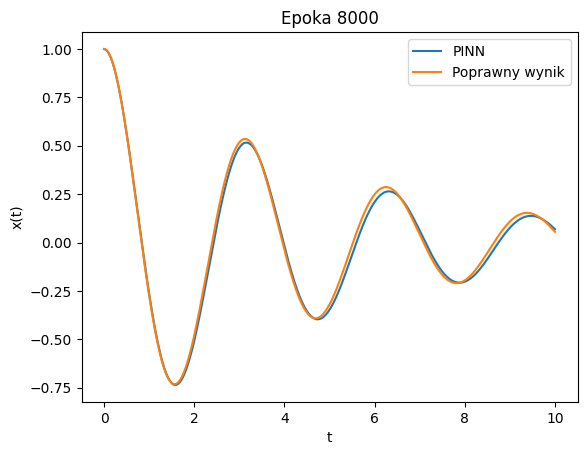

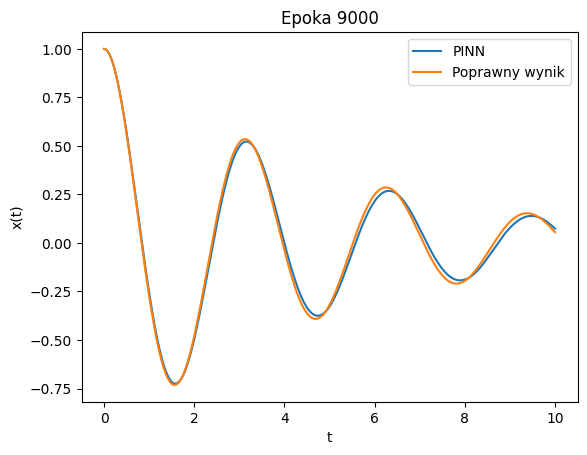

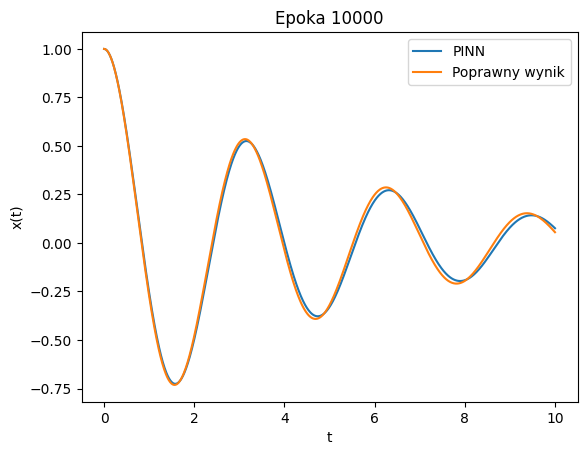

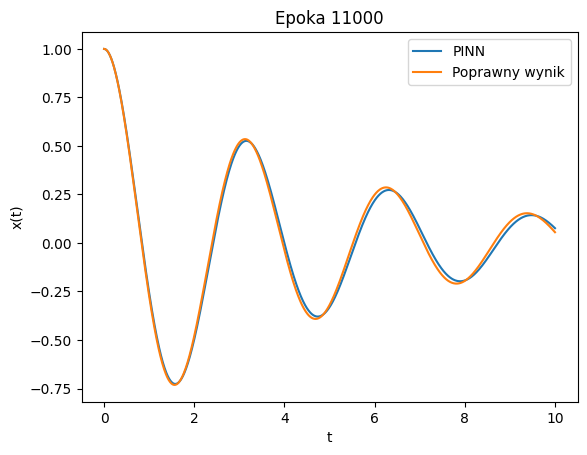

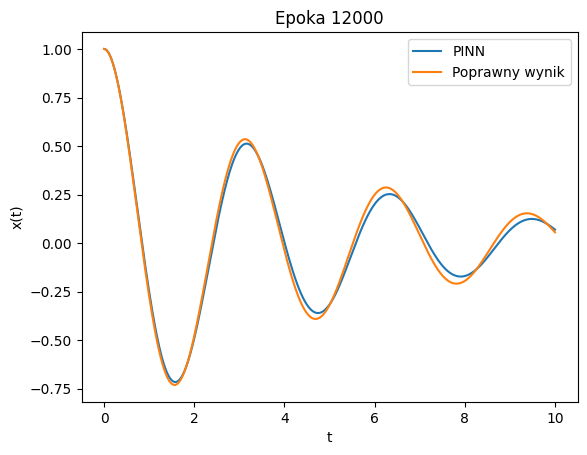

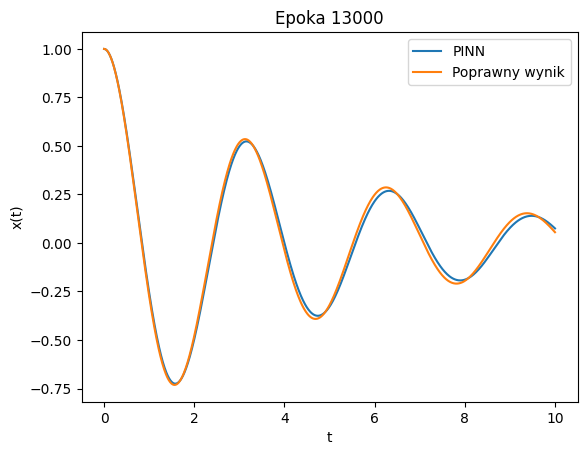

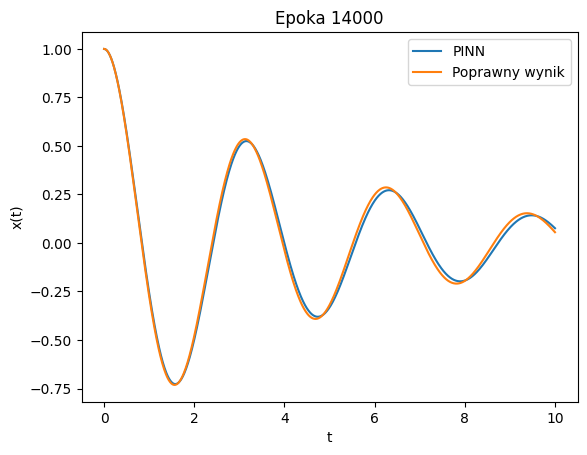

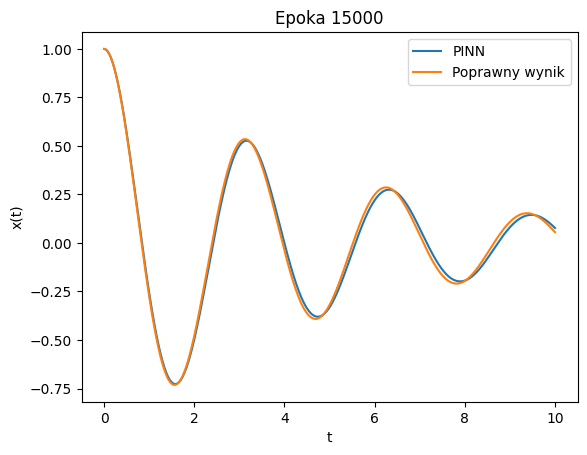

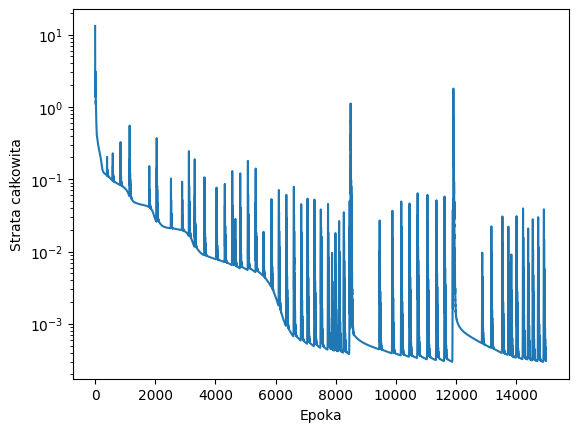

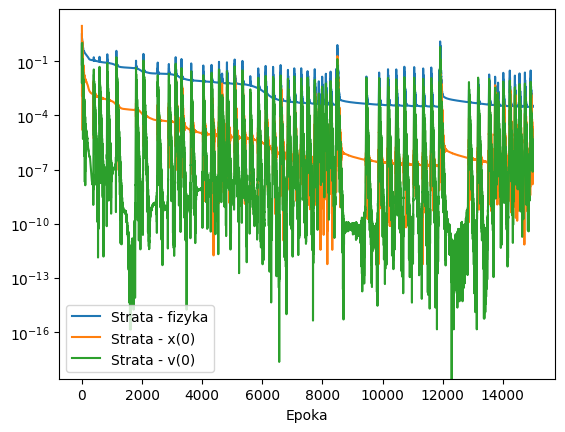

In [79]:
optimizer = torch.optim.Adam(pinn.parameters(), lr = LEARNING_RATE)

physics_loss_history = []
boundary_position_loss_history = []
boundary_velocity_loss_history = []
loss_history = []

for epoch in tqdm(range(NUM_EPOCHS)):
    pinn.train()

    # Strata - położenie początkowe
    x0_pred = pinn(t0_tensor)
    boundary_position_loss = LAMBDA_X0 * (x0_pred - x0_tensor) ** 2
    boundary_position_loss_history.append(boundary_position_loss.item())

    # Strata - prędkość początkowa
    v0_pred = torch.autograd.grad(x0_pred, t0_tensor, torch.ones_like(x0_pred),
                                  create_graph=True)[0]
    boundary_velocity_loss = LAMBDA_V0 * v0_pred ** 2
    boundary_velocity_loss_history.append(boundary_velocity_loss.item())

    # Strata - równanie Newtona
    x_pred = pinn(t_tensor)
    dx_dt = torch.autograd.grad(x_pred, t_tensor, torch.ones_like(x_pred), create_graph=True)[0]
    d2x_dt2 = torch.autograd.grad(dx_dt, t_tensor, torch.ones_like(dx_dt), create_graph = True)[0]
    # Sprawdź zgodność z prawami fizyki
    residual = d2x_dt2 + 2 * GAMMA * dx_dt + W_0**2 * x_pred
    physics_loss = LAMBDA_PHYSICS * torch.mean(residual**2)
    physics_loss_history.append(physics_loss.item())

    # Pełna strata
    loss = boundary_position_loss + boundary_velocity_loss + physics_loss
    loss_history.append(loss.item())

    # PyTorch
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch+1) % 1000 == 0:
        plot_result(pinn, W_0, GAMMA, T_MAX, title = f"Epoka {epoch+1}")

plt.plot(loss_history)
plt.xlabel("Epoka")
plt.ylabel("Strata całkowita")
plt.yscale("log")
plt.show()

plt.plot(physics_loss_history, label = "Strata - fizyka")
plt.plot(boundary_position_loss_history, label = "Strata - x(0)")
plt.plot(boundary_velocity_loss_history, label = "Strata - v(0)")
plt.xlabel("Epoka")
plt.yscale("log")
plt.legend()
plt.show()